In [55]:
import torch 
import pandas as pd
import numpy as np
from amlvae.models.VAE import VAE

import shap
from matplotlib import pyplot as plt
import gseapy as gp
import umap 
import seaborn as sbn

from sklearn.cluster import OPTICS, DBSCAN, HDBSCAN

from amlvae.models.MLP import MLP

import captum
from captum.attr import IntegratedGradients

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torch.load('../output/vae_l12_4-24-25.pt', weights_only=False)

model = model.to(device)
model = model.eval()

expr = pd.read_csv('../data/aml_expr.csv')
X = expr.iloc[:, 1:].values
X = torch.tensor(X, dtype=torch.float32, device=device)


In [ ]:
xhat = model.decode(model.encode(X)[0])
print('mse:', torch.mean((xhat - X) ** 2).item())
print('r2:', 1 - torch.mean((xhat - X) ** 2).item() / torch.var(X).item())

mse: 0.33217853307724
r2: 0.699553424473499


In [ ]:
class func(torch.nn.Module): 
    def __init__(self, vae): 
        super().__init__()
        self.vae = vae.eval()

    def forward(self, x):

        z = self.vae.encode(x)[0]

        return torch.abs(z).sum().view(1)

In [ ]:
eps = 0.01 # For SMOOTHGRAD

z0 = torch.zeros(1,12).to(device)
xb = model.decode(z0)
f = func(model).to(device)
ig = IntegratedGradients(f)

sample_gseas = [] 
score_dfs = []
for i,x in enumerate(X): 
    print(f'progress: {i}/{len(X)}', end='\r')
    
    # smoothGrad ...
    scores = []
    for i in range(3):
        xx = x + torch.randn_like(x) * eps
        scores.append( ig.attribute(x.view(1,-1), baselines=xb, n_steps=100).detach().cpu().numpy() )
    scores = np.concatenate(scores, axis=0).mean(0)

    tmp = pd.DataFrame({'gene_symbol': expr.columns[1:], 'score': scores.flatten()})
    score_dfs.append(tmp)
    tmp = tmp.sort_values('score', ascending=False) 
    
    prerank_res = gp.prerank(
        rnk=tmp,
        gene_sets=["Reactome_2016"],
        outdir=None,
        permutation_num=100, 
        seed=0
    )

    sample_gseas.append(prerank_res.res2d)


In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='correlation', random_state=42)
u = reducer.fit_transform(X.cpu().numpy())
df = pd.DataFrame(u, columns=['u1', 'u2']) 

In [ ]:
term_candidates = [] 
for gsea in sample_gseas: 
    term_candidates += gsea[lambda x: x['FDR q-val'] < 0.05]['Term'].tolist() 
term_candidates = np.unique( term_candidates  ) 

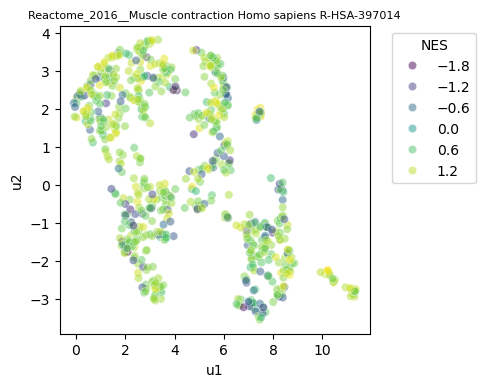

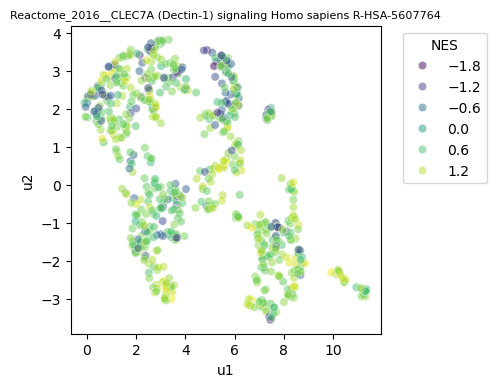

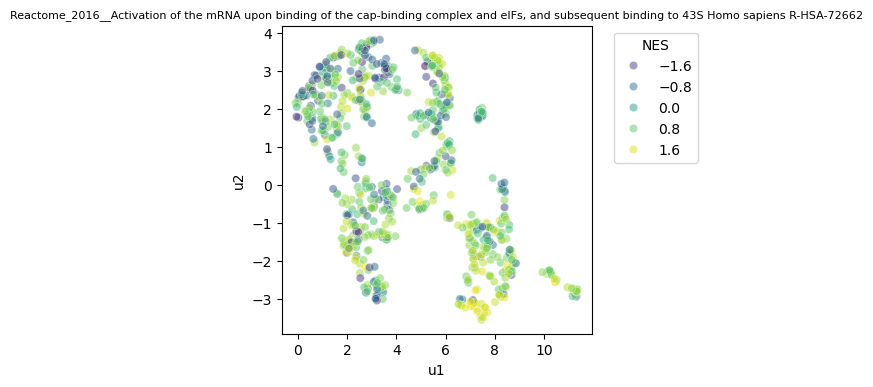

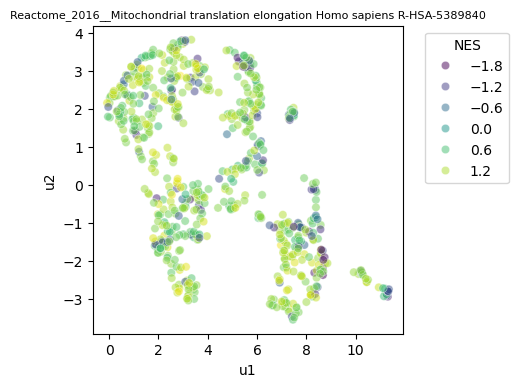

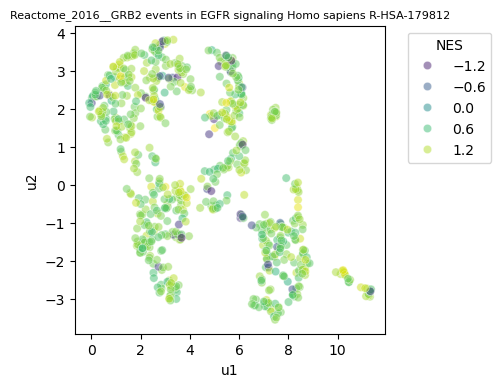

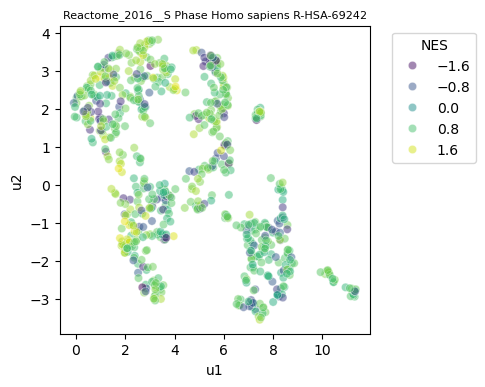

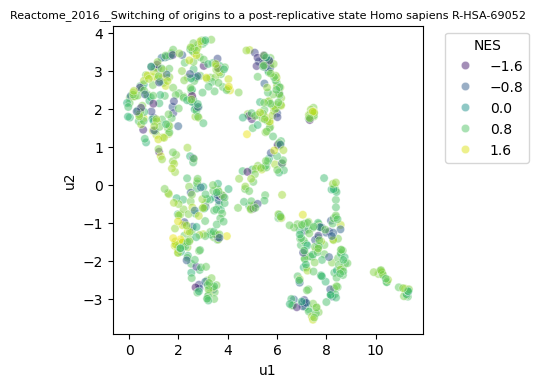

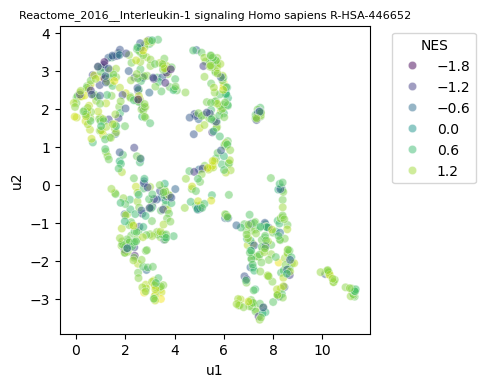

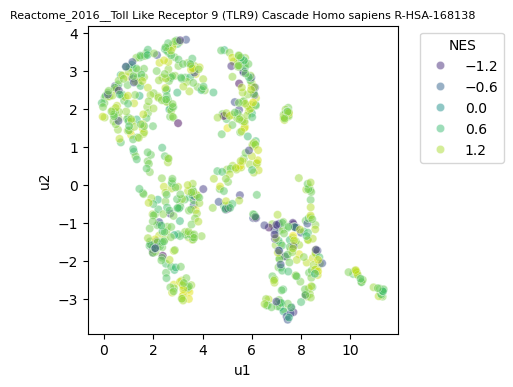

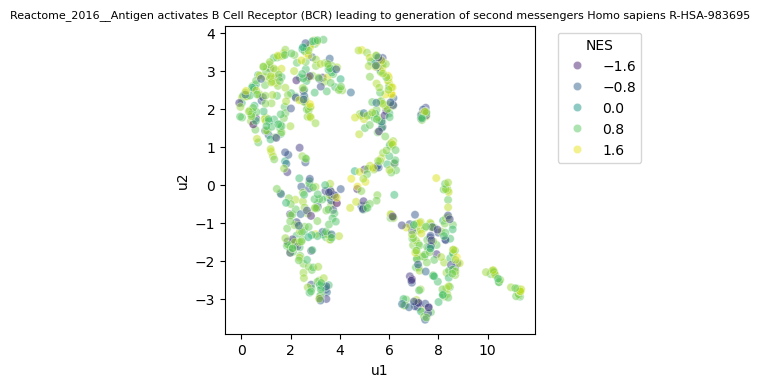

In [ ]:

for _term in np.random.choice(term_candidates, 10):
    terms_qval = [] 
    terms_nes = []
    for gsea in sample_gseas: 

        if _term in gsea.Term.values.tolist(): 
            #terms_qval.append(gsea.loc['Term', _term])
            terms_qval.append(gsea[lambda x: x.Term == _term]['FDR q-val'].values.item())
            terms_nes.append(gsea[lambda x: x.Term == _term]['NES'].values.item())
        else:
            terms_qval.append(None)
            terms_nes.append(None)

    df = df.assign(**{_term + '_qval': terms_qval, 
                     _term + '_nes': terms_nes}) 

    plt.figure(figsize=(6,6)) 
    sbn.scatterplot(data=df, x='u1', y='u2', hue=_term + '_nes', palette='viridis', alpha=0.5)
    #legend outside 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='NES')
    plt.title(_term, fontsize=8)
    plt.show() 